# Combine data

In [1]:
import pandas as pd
import os, os.path
import numpy as np
from itertools import product
from shapely.geometry import LinearRing, Polygon, Point, LineString, box
import geopandas as gpd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, asin, sqrt, atan2
from time import time
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [2]:
dir_name = "../data"
pickles = '../data/pickles/'
gcs_bucket = "https://storage.googleapis.com/w210data/"


if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
    
def download_file(file_name):
    full_path = os.path.join(dir_name, file_name)
    if not os.path.exists(full_path):
        urllib.urlretrieve (gcs_bucket+file_name, full_path)

download_file(pickles+'bathymetry.pkl')

# Read Pickle Files

In [3]:
os.listdir(pickles)

['aerial_kelp_hundreththkm.pkl',
 'aerial_kelp_tenthkm.pkl',
 'bathymetry.pkl',
 'boatlaunches.pkl',
 'ca_counties.pkl',
 'crit_species.pkl',
 'grid_df.pkl',
 'halibuttrawl.pkl',
 'kelp_beds.pkl',
 'kelp_biomass.pkl',
 'marinas.pkl',
 'min_light.pkl',
 'mixedl.pkl',
 'mpa.pkl',
 'nes_occupation.pkl',
 'oilplats.pkl',
 'piers.pkl',
 'ports.pkl',
 'qcew_occupation.pkl',
 'shoretypes.pkl',
 'sst_ca.pkl',
 'substrate.pkl',
 'temp_floor.pkl',
 'unemployment.pkl']

In [183]:
#we will need to convert some geometries from lat, lon to lon,lat
def flip_coords(geom):
    if type(geom) == Polygon:
        coords = geom.exterior.coords.xy 
        geomtype = 'Polygon'
    elif type(geom) == LineString:
        coords = geom.coords.xy
        geomtype = 'LineString'
    elif type(geom) == Point:
        coords = geom.coords.xy
        geomtype = 'Point'
    else:
        print("not a known geom type")
        return 
    flipped_coords = list(zip(coords[1],coords[0]))
    if geomtype == 'Polygon':
        return Polygon(flipped_coords) 
    elif geomtype == 'LineString':
        return LineString(flipped_coords)
    elif geomtype == 'Point':
        return Point(flipped_coords)

In [184]:
#Pickle files come from data/read_data.ipynb and
#bathymetry is not a gpd df
bathymetry = pd.read_pickle(pickles+'bathymetry.pkl')
print(bathymetry.shape)
bathymetry.head()

(5371, 4)


,x,y,z,geometry
1614,-124.45,40.400000,-50.0,POINT (-124.45 40.40000000000003)
1615,-124.45,40.416667,-38.0,POINT (-124.45 40.41666666666669)
1616,-124.45,40.433333,-32.0,POINT (-124.45 40.43333333333336)
1617,-124.45,40.450000,-29.0,POINT (-124.45 40.45000000000002)
1618,-124.45,40.466667,-31.0,POINT (-124.45 40.46666666666669)


In [185]:
#in lon, lat format
counties = pd.read_pickle(pickles+'ca_counties.pkl')
counties.head()

,STATEFP,COUNTYFP,NAME,geometry
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [186]:
#in lon lat format except for leatherbacks which is all messed up
crit_species = pd.read_pickle(pickles+'crit_species.pkl')
crit_species.head()

,species,geometry
0,black abalone,"POLYGON ((-123.5053264870277 38.7405412355896,..."
1,black abalone,POLYGON ((-123.0726524775298 38.31072869617242...
2,black abalone,POLYGON ((-122.5006060204515 37.50355915762907...
3,black abalone,POLYGON ((-122.5097393606829 37.50326748590578...
4,black abalone,POLYGON ((-122.4114904047584 37.26741997175435...


In [187]:
#in lat lon format
protected_areas = pd.read_pickle(pickles+'mpa.pkl')
protected_areas.Geometry = protected_areas.Geometry.apply(flip_coords)
protected_areas = gpd.GeoDataFrame(protected_areas, crs = {'init' :'epsg:4326'}, geometry='Geometry')

In [188]:
#does not have geom. just county names (and fips state and county codes)
occupation_nes = pd.read_pickle(pickles+'nes_occupation.pkl')
occupation_nes.head()

,estab,estab_f,naics,year,State,fips_state,fips_county,name,STATE,COUNTY,STNAME,CTYNAME,population,pct
0,42,NaN,11411,2010,CA,6,1,Alameda County,6,1,California,Alameda County,1513402,0.000028
1,71,NaN,11411,2011,CA,6,1,Alameda County,6,1,California,Alameda County,1532215,0.000046
2,63,NaN,11411,2012,CA,6,1,Alameda County,6,1,California,Alameda County,1556648,0.000040
3,65,NaN,11411,2013,CA,6,1,Alameda County,6,1,California,Alameda County,1582936,0.000041
4,64,NaN,11411,2014,CA,6,1,Alameda County,6,1,California,Alameda County,1611572,0.000040


In [189]:
#does not have geom. just county names (and fips state and county codes)
occupation_qcew = pd.read_pickle(pickles+'qcew_occupation.pkl')
occupation_qcew.head()

,area_fips,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,fips_county,fips_state,State,name,fips_class_code,STATE,COUNTY,STNAME,CTYNAME,population,estab_pct,emp_pct
0,06007,11251,77,0,2013,N,1,0,7,6,CA,Butte County,H1,6,7,California,Butte County,221768,0.000005,0.000000
1,06015,11251,77,0,2013,N,1,0,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.000036,0.000000
2,06015,11411,77,0,2013,NaN,39,81,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.001401,0.002911
3,06019,11251,77,0,2013,N,4,0,19,6,CA,Fresno County,H1,6,19,California,Fresno County,953787,0.000004,0.000000
4,06023,11251,77,0,2013,NaN,6,19,23,6,CA,Humboldt County,H1,6,23,California,Humboldt County,134444,0.000045,0.000141


In [190]:
unemployment = pd.read_pickle(pickles+'unemployment.pkl')

In [191]:
#in lat lon format
kelp_biomass =pd.read_pickle(pickles+'kelp_biomass.pkl')
kelp_biomass.geometry = kelp_biomass.geometry.apply(flip_coords)
kelp_biomass.head()
#kelp_biomass.geometry.apply(type).unique() all points

,lat,lon,biomass,geometry
0,32.519277,-117.142836,265.0,POINT (-117.1428356 32.51927713)
1,32.519547,-117.143155,635.0,POINT (-117.1431554 32.5195474)
2,32.519548,-117.142836,275.0,POINT (-117.142836 32.51954776)
3,32.519548,-117.142197,272.0,POINT (-117.1421972 32.51954849)
4,32.519818,-117.143156,565.0,POINT (-117.1431559 32.51981803)


In [192]:
#will be converted to lon lat format
sst = pd.read_pickle(pickles+'sst_ca.pkl')
sst.geometry = sst.geometry.apply(flip_coords)
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


# read minimum light depth

In [193]:
z_min_light = pd.read_pickle(pickles+'min_light.pkl')
z_min_light.head()
#plt.hist(z_min_light.z_min_light)

,geometry,z_min_light
index_left,,
0,POINT (-124.4791717529297 42.1875),35
1,POINT (-124.4375076293945 42.1875),35
2,POINT (-124.3958358764648 42.1875),0
3,POINT (-124.3541717529297 42.1875),0
4,POINT (-124.3125076293945 42.1875),0


# read mixed layer

In [194]:
mixedl = pd.read_pickle(pickles+'mixedl.pkl')
mixedl.head()
#plt.hist(mixedl.mean_mld)

,geometry,mean_mld
iNPROF,,
2325,POINT (-123.031997680664 36.3499984741211),17.643838
2326,POINT (-122.782997131348 36.2389984130859),19.306555
2327,POINT (-122.656997680664 36.0320014953613),17.594704
2328,POINT (-122.785003662109 35.9490013122559),31.267630
2329,POINT (-122.830001831055 35.9910011291504),30.126088


# read ocean floor temps

In [195]:
floor_temps = pd.read_pickle(pickles+'temp_floor.pkl')

# Create grid of California

In [4]:
def squarify(point, increment):
    return Polygon([(point[0], point[1]),
     (point[0] + increment, point[1]), 
     (point[0] + increment, point[1] + increment), 
     (point[0], point[1] + increment)])

def desquarify(left_vertices, right_vertices, square_length):
    x_num = round((right_vertices[0] - left_vertices[0])/square_length, 0)
    y_num = round((right_vertices[1] - left_vertices[1])/square_length, 0)
    x_lengths = np.linspace(left_vertices[0], right_vertices[0]-square_length, x_num)
    y_lengths = np.linspace(left_vertices[1], right_vertices[1]-square_length, y_num)
    return [p for p in product(x_lengths, y_lengths)]

In [5]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [6]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [7]:
#create vertices for California
#roughly the bounds of california going out 8km past cape mendocino
width = .1
#(32.534343,-124.511849),(42.00,-117.123885)
grid_bottomleft_vertices = desquarify((-124.511849,32.534343),(-117.123885,42), width)
grid = [squarify(i, width) for i in grid_bottomleft_vertices]
grid_df = gpd.GeoDataFrame(geometry=grid, crs = {'init' : 'epsg:4326'})
grid_df["polygon_id"] = range(len(grid))

# Cull data to just areas near coast and not on land
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

# cull polygons on land
print("before culling land there are {} rows".format(grid_df.shape[0]))
grid_df = gpd.sjoin(grid_df, land, op='within', how='left')
print(grid_df.head())
grid_df.fillna(-99999, inplace=True)
grid_df = grid_df[grid_df['index_right'] <0]
print("after culling land there are {} rows".format(grid_df.shape[0]))
grid_df = grid_df.iloc[:,:2]

#cull polygons far from shore
#EEZ extends 3 nautical miles (5.556 km) from coast. 
eez = 5.556
print("before culling far away sites there are {} rows".format(grid_df.shape[0]))
grid_df['land_distance'] = grid_df.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
grid_df = grid_df[grid_df['land_distance'] <eez]
print("after culling far away sites there are {} rows".format(grid_df.shape[0]))
print(grid_df.shape)
print(len(grid_df.polygon_id.unique()))
grid_df.head()

/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


before culling land there are 7030 rows
                                            geometry  polygon_id  index_right  \
0  POLYGON ((-124.511849 32.534343, -124.411849 3...           0          NaN   
1  POLYGON ((-124.511849 32.63397764893617, -124....           1          NaN   
2  POLYGON ((-124.511849 32.73361229787234, -124....           2          NaN   
3  POLYGON ((-124.511849 32.83324694680851, -124....           3          NaN   
4  POLYGON ((-124.511849 32.93288159574468, -124....           4          NaN   

  STATEFP STATENS AFFGEOID GEOID STUSPS NAME LSAD  ALAND  AWATER  
0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
1     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
2     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
3     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
4     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
after culling land there are 3880 rows
before culling far away sites th

,geometry,polygon_id,land_distance
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525


# Combine Data

In [9]:
def get_closest_areas(shape,areas, area_names,max_distance, min_returned=3, max_returned=None):
    distance_ratio = get_distance_ratio(shape)
    distances = [shape.distance(i)*distance_ratio for i in areas]
    sorted_distances = np.sort(distances)
    areas_within_max = sorted_distances < max_distance
    num_close_areas = sum(areas_within_max)
    if num_close_areas < min_returned:
        lowest_distances = sorted_distances[:min_returned]
        area_idx = np.argsort(distances)[:min_returned]
    else:
        lowest_distances = sorted_distances[:num_close_areas]
        area_idx = np.argsort(distances)[:num_close_areas]
    
    if max_returned:
        area_idx = area_idx[:max_returned]
        lowest_distances = lowest_distances[:max_returned]
        
    names = area_names.iloc[area_idx]
    return list(zip(area_idx, names, lowest_distances))

In [201]:
#distance in km does seem to vary for the same difference in latitude/long depending on your latitude.
print(haversine((-122,32.5),(-121,32.5)))
print(haversine((-122,32.5),(-122,33.5)))
print(haversine((-122,42),(-121,42)))
print(haversine((-122,42),(-122,41)))
print(haversine((-122,41),(-122.0166667,41)))

93.80994612038263
111.22983322959878
82.65940525349976
111.22983322959878
1.3991064751674347


In [202]:
grid_df['pretected_areas'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,protected_areas.Geometry,\
                                                                                protected_areas.Name,\
                                                                                10))
grid_df['county'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.NAME,\
                                                                                10,1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]"
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]"
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]"
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]"
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]"


In [203]:
grid_df['critical_species'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,crit_species.geometry,\
                                                                                crit_species.species,\
                                                                                10))
grid_df['critical_species'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,protected_areas.geometry,\
                                                                                protected_areas.Name,\
                                                                                10))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0..."
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0..."
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (..."
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469..."
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,..."


In [204]:
grid_df.iloc[0].pretected_areas[0][2]

0.0

## merge occupation data

In [205]:
#get mean levels for establishments and employment and aggregate by year
occupation_avg_qcew = occupation_qcew.groupby(['fips_county','fips_state','industry_code']).mean().reset_index()
occupation_avg_qcew.drop(occupation_avg_qcew.columns[7:10], axis=1, inplace=True)
occupation_avg_qcew.drop(['agglvl_code','size_code'], axis = 1, inplace=True)
occupation_avg_qcew = occupation_avg_qcew.rename(columns={'estab_pct':'qcew_estab_pct','emp_pct':'qcew_emp_pct',\
                                                         'industry_code':'naics'})
occupation_avg_qcew.head()

,fips_county,fips_state,naics,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct
0,1,6,11251,0.00,0.0,0.000000e+00,0.0
1,1,6,11411,2.80,0.0,1.721269e-06,0.0
2,7,6,11251,0.50,0.0,2.254608e-06,0.0
3,7,6,11411,1.25,0.0,5.541791e-06,0.0
4,13,6,11251,1.00,0.0,8.844836e-07,0.0


In [206]:
occupation_avg_nes = occupation_nes.groupby(['fips_county','fips_state','naics']).mean().reset_index()
occupation_avg_nes.drop(['STATE','COUNTY','population'], axis=1, inplace=True)
occupation_avg_nes = occupation_avg_nes.rename(columns={'pct':'nes_estab_pct'})
occupation_avg_nes.naics = occupation_avg_nes.naics.astype(int)
occupation_avg_nes.head()

,fips_county,fips_state,naics,estab,nes_estab_pct
0,1,6,11411,58.666667,0.000037
1,5,6,11411,0.000000,0.000000
2,7,6,11411,31.666667,0.000143
3,9,6,11411,10.500000,0.000234
4,11,6,11411,2.833333,0.000133


In [207]:
#combine new and qcew data
all_occupation = occupation_avg_nes.merge(occupation_avg_qcew, on=['fips_county','fips_state','naics'], how='outer')\
                                   .merge(unemployment, on=['fips_county','fips_state'], how='outer')
all_occupation.head()
#all_occupation[all_occupation['fips_county'] == 75].head()

,fips_county,fips_state,naics,estab,nes_estab_pct,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct,unemployment_rate
0,1,6,11411.0,58.666667,0.000037,2.80,0.0,0.000002,0.0,3.307143
1,1,6,11251.0,NaN,NaN,0.00,0.0,0.000000,0.0,3.307143
2,5,6,11411.0,0.000000,0.000000,NaN,NaN,NaN,NaN,4.428571
3,7,6,11411.0,31.666667,0.000143,1.25,0.0,0.000006,0.0,5.264286
4,7,6,11251.0,NaN,NaN,0.50,0.0,0.000002,0.0,5.264286


In [208]:
counties.head()

,STATEFP,COUNTYFP,NAME,geometry
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [209]:
counties = counties.merge(all_occupation, left_on=['STATEFP','COUNTYFP'], right_on=['fips_state','fips_county'], how='outer')
counties.drop(['fips_county','fips_state'], axis=1, inplace=True)
#exclude 11251 naics codes
counties = counties[counties.naics == 11411]
counties.head()

,STATEFP,COUNTYFP,NAME,geometry,naics,estab,nes_estab_pct,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct,unemployment_rate
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37...",11411.0,40.333333,0.000048,1.0,0.0,1.157428e-06,0.000000,2.642857
2,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3...",11411.0,76.166667,0.000284,4.8,5.0,1.752913e-05,0.000018,5.257143
4,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3...",11411.0,0.666667,0.000004,NaN,NaN,NaN,NaN,8.250000
5,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3...",11411.0,62.166667,0.000034,1.0,0.0,5.233124e-07,0.000000,2.914286
6,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3...",11411.0,5.500000,0.000197,NaN,NaN,NaN,NaN,6.921429


In [210]:
counties.shape

(57, 12)

In [211]:
grid_df['nes_estab_pct'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.nes_estab_pct,\
                                                                                10,1,1))
grid_df['annual_avg_emplvl'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.annual_avg_emplvl,\
                                                                                10,1,1))
grid_df['qcew_emp_pct'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.qcew_emp_pct,\
                                                                                10,1,1))
grid_df['unemployment_rate'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.unemployment_rate,\
                                                                                10,1,1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]"
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]"
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]"
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]"
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]"


## merge kelp data

In [212]:
#grid_df.geometry.apply(lambda x: join_kelp_mass(x, kelp_biomass.geometry))
print(grid_df.head())
print(kelp_biomass.head())
gridded_kelp_biomass = gpd.sjoin(grid_df, kelp_biomass, op='intersects', how="left")
print(gridded_kelp_biomass.shape)
gridded_kelp_biomass.drop(["index_right","lat","lon","land_distance"], axis=1, inplace=True)
gridded_kelp_biomass = gridded_kelp_biomass.groupby(['polygon_id']).sum().reset_index()
#columns are polygon_id and biomass
gridded_kelp_biomass.head()

                                              geometry  polygon_id  \
77   POLYGON ((-124.511849 40.2062109680851, -124.4...          77   
78   POLYGON ((-124.511849 40.30584561702128, -124....          78   
79   POLYGON ((-124.511849 40.40548026595744, -124....          79   
80   POLYGON ((-124.511849 40.50511491489362, -124....          80   
171  POLYGON ((-124.4120138767123 40.10657631914894...         171   

     land_distance                                    pretected_areas  \
77        4.785556  [(13, Sea Lion Gulch State Marine Reserve, 0.0...   
78        2.007310  [(12, Mattole Canyon State Marine Reserve, 0.0...   
79        0.222856  [(9, Sugarloaf Island Special Closure, 0.0), (...   
80        2.325414  [(9, Sugarloaf Island Special Closure, 6.54469...   
171       1.252525  [(14, Big Flat State Marine Conservation Area,...   

                                    county  \
77     [(21, Humboldt, 4.785556275622082)]   
78      [(21, Humboldt, 2.00731033547805)]   
79

,polygon_id,biomass
0,77,0.0
1,78,0.0
2,79,0.0
3,80,0.0
4,171,0.0


In [213]:
grid_df = grid_df.merge(gridded_kelp_biomass, on='polygon_id', how="left")
grid_df[grid_df['biomass'] >1].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass
137,POLYGON ((-122.3154762876712 37.01790220212766...,2135,0.000000,"[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(1, Santa Cruz, 0.0), (13, San Mateo, 0.0)]","[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(1, 0.0002835365602559534, 0.0)]","[(1, 5.0, 0.0)]","[(1, 1.8141170620894354e-05, 0.0)]","[(1, 5.257142857142857, 0.0)]",103062.0
144,POLYGON ((-122.2156411643836 36.91826755319149...,2229,0.000000,"[(50, Natural Bridges State Marine Reserve, 0....","[(1, Santa Cruz, 0.0)]","[(50, Natural Bridges State Marine Reserve, 0....","[(1, 0.0002835365602559534, 0.0)]","[(1, 5.0, 0.0)]","[(1, 1.8141170620894354e-05, 0.0)]","[(1, 5.257142857142857, 0.0)]",416871.0
151,POLYGON ((-122.1158060410959 36.91826755319149...,2324,0.000000,"[(50, Natural Bridges State Marine Reserve, 0....","[(1, Santa Cruz, 0.0)]","[(50, Natural Bridges State Marine Reserve, 0....","[(1, 0.0002835365602559534, 0.0)]","[(1, 5.0, 0.0)]","[(1, 1.8141170620894354e-05, 0.0)]","[(1, 5.257142857142857, 0.0)]",687033.0
154,POLYGON ((-122.0159709178082 36.32045965957447...,2413,0.145613,"[(61, Point Sur State Marine Reserve, 1.390695...","[(18, Monterey, 0.14561259121612838)]","[(61, Point Sur State Marine Reserve, 1.390695...","[(18, 0.00041362812133820384, 0.14561259121612...","[(18, 34.8, 0.14561259121612838)]","[(18, 8.045620752826679e-05, 0.145612591216128...","[(18, 6.728571428571429, 0.14561259121612838)]",61180.0
155,POLYGON ((-122.0159709178082 36.42009430851063...,2414,0.000000,"[(59, Point Lobos State Marine Reserve, 0.0), ...","[(18, Monterey, 0.0)]","[(59, Point Lobos State Marine Reserve, 0.0), ...","[(18, 0.00041362812133820384, 0.0)]","[(18, 34.8, 0.0)]","[(18, 8.045620752826679e-05, 0.0)]","[(18, 6.728571428571429, 0.0)]",564670.0


In [214]:
g1 = pd.Series([Point((0.25,0.25)),Point(1.5,0.25),Point((1.25,.25)),Point((2.25,0.25)),Point((3.25,0.25)),Point(4.25,0.25)])

In [215]:
a = gpd.GeoDataFrame(geometry=g1)

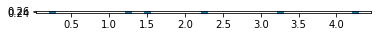

In [216]:
a.plot()

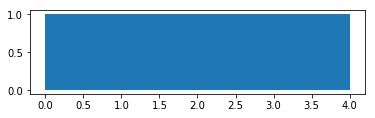

In [217]:
g2 = pd.Series([box(0,0,1,1),box(1,0,2,1),box(2,0,3,1),box(3,0,4,1)])
b = gpd.GeoDataFrame(geometry=g2)
b.plot()

In [218]:
joined = gpd.sjoin(a,b, op="within", how='right')
joined.head()

,index_left,geometry
index_right,,
0,0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))"
1,2,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))"
1,1,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))"
2,3,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))"
3,4,"POLYGON ((4 0, 4 1, 3 1, 3 0, 4 0))"


In [219]:
joined.dissolve(by=joined.index)

,geometry,index_left
index_right,,
0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))",0
1,"POLYGON ((2 1, 2 0, 1 0, 1 1, 2 1))",2
2,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))",3
3,"POLYGON ((4 0, 4 1, 3 1, 3 0, 4 0))",4


In [220]:
a = box(0,0,1,1)
b = Point(0,0)
c = Point(.5,.5)
d = Point(.5,0)
a.contains(d)

False

## merge bathymetry data

In [221]:
bathymetry.head()
bathymetry.shape

(5371, 4)

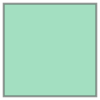

In [222]:
grid_df.iloc[0].geometry

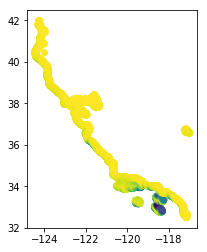

In [223]:
bathymetry.plot(column='z')

In [224]:
def get_value_at_point(shape, pnts, vals, n_closest=5):
    distances = [shape.distance(i) for i in pnts]
    closest_points = np.argsort(distances)[:n_closest]
    return np.mean(vals.iloc[closest_points])

In [225]:
#get_value_at_point(grid_df.geometry, ocean_bathymetry.geometry, ocean_bathymetry.z)
grid_df['depth'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, bathymetry.geometry, bathymetry.z))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2


# merge sst data

In [226]:
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


In [227]:
grid_df['mean_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.mean_temp))
grid_df['max_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.max_temp))
grid_df['min_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.min_temp))
#a = get_value_at_point(grid_df.iloc[1].geometry, sst.geometry,sst.mean_temp)
#print(a)
#print(sst.iloc[898])
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995


# merge ndvi

In [228]:
ndvi = pd.read_csv('../spectral/ndvi.csv')
geom = ndvi.apply(lambda x : Point([x['lon'],x['lat']]), axis=1)
ndvi = gpd.GeoDataFrame(ndvi, geometry = geom, crs = {'init' : 'epsg:4326'})
ndvi.drop(['lat','lon'], axis=1, inplace=True)
ndvi.head()

,ndvi,geometry
0,0.008434,POINT (-122.1670025170002 36.99928121643993)
1,-0.020347,POINT (-122.1497959339712 36.98521902016441)
2,0.014294,POINT (-122.1239862600261 36.97115679037713)
3,-0.020140,POINT (-122.115383089949 36.96412566291804)
4,-0.014558,POINT (-122.0981768332691 36.95709452708277)


In [229]:
grid_df['ndvi'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, ndvi.geometry, ndvi.ndvi, n_closest=1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995,0.008434
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995,0.008434
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995,0.008434
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995,0.008434


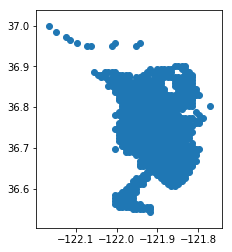

In [230]:
ndvi.plot()

# merge minimum light

In [231]:
grid_df['z_min_light'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, z_min_light.geometry, z_min_light.z_min_light))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995,0.008434,43.0
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434,46.0
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995,0.008434,28.0
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995,0.008434,32.0
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995,0.008434,42.0


# merge mixed layer

In [232]:
grid_df['z_mixedl'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, mixedl.geometry, mixedl.mean_mld))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995,0.008434,43.0,17.955626
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434,46.0,17.955626
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995,0.008434,28.0,17.955626
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995,0.008434,32.0,17.955626
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995,0.008434,42.0,17.955626


# merge seafloor temperatures

In [233]:
grid_df['floor_temp'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, floor_temps.geometry, floor_temps.temp_floor))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995,0.008434,43.0,17.955626,8.584
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434,46.0,17.955626,8.156
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995,0.008434,32.0,17.955626,8.156
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995,0.008434,42.0,17.955626,8.910


# use formula to say which sites are good for kelp

In [234]:
#based on http://www.pnas.org/content/104/42/16576
def viable_site(row):
    right_temp = row.floor_temp <= 23
    floor_below_mixedl = -row.depth >= row.z_mixedl
    minimum_light = -row.depth <= row.z_min_light
    #return if all the above conditions are met
    return right_temp and floor_below_mixedl and minimum_light

grid_df['viable'] = grid_df.apply(viable_site, axis=1)
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp,viable
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",0.0,-122.4,11.929242,14.013989,9.125995,0.008434,43.0,17.955626,8.584,False
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434,46.0,17.955626,8.156,True
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",0.0,-29.6,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156,False
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",0.0,-38.6,11.929242,14.013989,9.125995,0.008434,32.0,17.955626,8.156,False
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",0.0,-58.2,11.929242,14.013989,9.125995,0.008434,42.0,17.955626,8.910,False


In [235]:
grid_df[grid_df.viable == True].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp,viable
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",0.0,-45.0,11.929242,14.013989,9.125995,0.008434,46.0,17.955626,8.156,True
10,POLYGON ((-124.4120138767123 40.70438421276596...,177,3.342186,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 3.3421855155768077)]","[(8, South Humboldt Bay State Marine Recreatio...","[(21, 0.0016440403180747229, 3.3421855155768077)]","[(21, 23.0, 3.3421855155768077)]","[(21, 0.000169361125824495, 3.3421855155768077)]","[(21, 3.8285714285714287, 3.3421855155768077)]",0.0,-28.6,11.929242,14.013989,9.125995,0.008434,30.0,17.955626,8.742,True
24,"POLYGON ((-124.212343630137 39.90730702127659,...",359,4.516364,"[(15, Double Cone Rock State Marine Conservati...","[(21, Humboldt, 4.5163637066287174), (43, Mend...","[(15, Double Cone Rock State Marine Conservati...","[(21, 0.0016440403180747229, 4.5163637066287174)]","[(21, 23.0, 4.5163637066287174)]","[(21, 0.000169361125824495, 4.5163637066287174)]","[(21, 3.8285714285714287, 4.5163637066287174)]",0.0,-48.4,11.929242,14.013989,9.125995,0.008434,52.0,19.463964,8.744,True
33,"POLYGON ((-124.212343630137 41.30219210638298,...",373,2.203451,"[(5, Reading Rock State Marine Conservation Ar...","[(21, Humboldt, 2.203451051550548), (45, Del N...","[(5, Reading Rock State Marine Conservation Ar...","[(21, 0.0016440403180747229, 2.203451051550548)]","[(21, 23.0, 2.203451051550548)]","[(21, 0.000169361125824495, 2.203451051550548)]","[(21, 3.8285714285714287, 2.203451051550548)]",0.0,-22.2,11.929242,14.013989,9.125995,0.008434,23.0,17.955626,8.986,True
40,POLYGON ((-124.1125085068493 39.80767237234043...,453,5.224822,"[(15, Double Cone Rock State Marine Conservati...","[(43, Mendocino, 5.224822059093919), (21, Humb...","[(15, Double Cone Rock State Marine Conservati...","[(42, 0.0017240141841386644, 5.224822059093919)]","[(42, 35.0, 5.224822059093919)]","[(42, 0.0003996363410896306, 5.224822059093919)]","[(42, 4.135714285714286, 5.224822059093919)]",0.0,-41.8,11.929242,14.013989,9.125995,0.008434,46.0,22.812879,8.966,True


In [236]:
print(grid_df.z_min_light.mean())
print(grid_df.z_mixedl.mean())
print(grid_df.depth.mean())
print(grid_df.floor_temp.mean())
print(grid_df.shape)
print(grid_df[grid_df.viable == True].shape)

21.319755600814663
18.88986836891018
-71.36537678207728
9.72399918533603
(491, 20)
(31, 20)


(array([ 2.,  0.,  0.,  0.,  0.,  0., 42.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  1.,  4.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  5.,  3.,
         8.,  2., 25., 24., 12., 24., 27.,  7., 48.,  8., 23., 52., 40.,
        36., 26.,  9., 15., 12.,  5.,  3.,  4.,  5.,  3.,  8.]),
 array([ 1.506   ,  1.754736,  2.003472,  2.252208,  2.500944,  2.74968 ,
         2.998416,  3.247152,  3.495888,  3.744624,  3.99336 ,  4.242096,
         4.490832,  4.739568,  4.988304,  5.23704 ,  5.485776,  5.734512,
         5.983248,  6.231984,  6.48072 ,  6.729456,  6.978192,  7.226928,
         7.475664,  7.7244  ,  7.973136,  8.221872,  8.470608,  8.719344,
         8.96808 ,  9.216816,  9.465552,  9.714288,  9.963024, 10.21176 ,
        10.460496, 10.709232, 10.957968, 11.206704, 11.45544 , 11.704176,
        11.952912, 12.201648, 12.450384, 12.69912 , 12.947856, 13.196592,
        13.445328, 13.694064, 13.9428  ]),
 <a list of 50 Patch objects>)

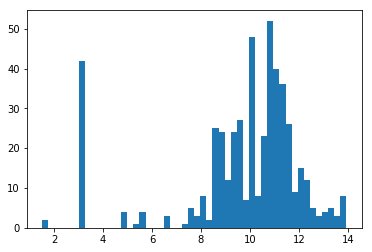

In [237]:
plt.hist(grid_df.floor_temp, bins=50)

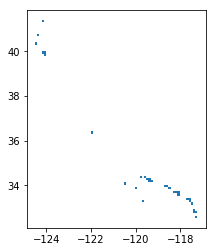

In [238]:
grid_df[grid_df.viable == True].plot()

# merge boat launch sites

In [239]:
boatlaunches = pd.read_pickle(pickles+'boatlaunches.pkl')
grid_df['boat_launches'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,boatlaunches.geometry,\
                                                                                boatlaunches.Type,\
                                                                                10,1))

# merge halibut trawl areas

In [240]:
halibuttrawl = pd.read_pickle(pickles+'halibuttrawl.pkl')
grid_df['halibut_trawl_sites'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,halibuttrawl.geometry,\
                                                                                halibuttrawl.Status,\
                                                                                10,0))

# merge marina data

In [241]:
marinas = pd.read_pickle(pickles+'marinas.pkl')
grid_df['marinas'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,marinas.geometry,\
                                                                                marinas.Name,\
                                                                                10,0))

# merge port data

In [242]:
ports = pd.read_pickle(pickles+'ports.pkl')
#ports.head()
grid_df['ports'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,ports.geometry,\
                                                                        ports.FEAT_NAME,\
                                                                                10,0))

# merge oil platform data

In [243]:
oilplats = pd.read_pickle(pickles+'oilplats.pkl')
grid_df['oil_platforms'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,oilplats.geometry,\
                                                                                oilplats.NAME,\
                                                                                10,0))

# merge piers data

In [244]:
piers = pd.read_pickle(pickles+'piers.pkl')
grid_df['piers'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,piers.geometry,\
                                                                        piers.PNT_NAME,\
                                                                        1,0))
grid_df[grid_df.piers.apply(len)>0].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,z_min_light,z_mixedl,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,ports,oil_platforms,piers
15,POLYGON ((-124.3121787534247 40.70438421276596...,272,0.0,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(8, South Humboldt Bay State Marine Recreatio...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,10.0,17.955626,8.7520,False,"[(52, Launch Ramp, 0.0), (118, Launch Ramp, 0....",[],"[(193, The Local Fish Company (former King Sal...","[(87, King Salmon, 0.0), (85, Fields Landing, ...",[],"[(145, North Jetty Humboldt Bay, 0.0), (45, Ki..."
27,"POLYGON ((-124.212343630137 40.70438421276596,...",367,0.0,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(8, South Humboldt Bay State Marine Recreatio...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,0.0,19.091760,8.7520,False,"[(119, Launch Ramp, 0.0), (52, Launch Ramp, 0....",[],"[(195, Eureka Public Marina, 0.0), (193, The L...","[(84, Eureka, 0.0), (7, Humboldt Bay, 0.0), (8...",[],"[(144, Eureka Marina: Warfinger Pier, 0.0), (1..."
28,"POLYGON ((-124.212343630137 40.80401886170213,...",368,0.0,"[(7, Samoa State Marine Conservation Area, 0.0...","[(21, Humboldt, 0.0)]","[(7, Samoa State Marine Conservation Area, 0.0...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,0.0,17.955626,9.1100,False,"[(120, Hoist, 0.0), (53, Launch Ramp, 0.0), (1...",[],"[(194, Woodley Island Marina, 0.0), (195, Eure...","[(84, Eureka, 1.5321345943035483), (7, Humbold...",[],"[(143, Boonie Gool Guest Dock, 0.0), (48, Eure..."
30,"POLYGON ((-124.212343630137 41.00328815957447,...",370,0.0,"[(7, Samoa State Marine Conservation Area, 8.5...","[(21, Humboldt, 0.0)]","[(7, Samoa State Marine Conservation Area, 8.5...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,5.0,17.955626,9.1100,False,"[(55, Hoist, 0.0), (56, Launch Ramp, 5.9659437...",[],"[(196, Seascape Trinidad Harbor, 0.0)]","[(92, Trinidad, 0.0)]",[],"[(150, Trinidad Pier, 0.0)]"
37,"POLYGON ((-124.212343630137 41.70073070212766,...",377,0.0,"[(3, Castle Rock Special Closure, 3.6066867366...","[(45, Del Norte, 0.0)]","[(3, Castle Rock Special Closure, 3.6066867366...","[(44, 0.005198903773005844, 0.0)]","[(44, 63.6, 0.0)]","[(44, 0.0023123701246148707, 0.0)]","[(44, 5.921428571428571, 0.0)]",...,0.0,17.955626,9.4964,False,"[(123, Hoist, 0.0), (66, Launch Ramp, 0.0), (6...",[],"[(198, Crescent City Harbor District, 0.0), (1...","[(83, Cresent City, 0.0)]",[],"[(43, Crescent City Harbor Docks, 0.0), (42, M..."


# merge shoretypes data

In [245]:
shoretype = pd.read_pickle(pickles+'shoretypes.pkl')
grid_df['shoretype'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,shoretype.geometry,\
                                                                        shoretype.mapclass,\
                                                                        1,1,1))

In [246]:
t0 = time()
grid_df['shoretype2'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,shoretype.geometry,\
                                                                        shoretype.s1name,\
                                                                        1,1,1))
print(time() - t0)
grid_df.head()

342.0981676578522


,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,ports,oil_platforms,piers,shoretype,shoretype2
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",...,8.584,False,"[(49, Launch Ramp, 35.1320479402703)]",[],[],[],[],[],"[(5449, Rocky Shores, 4.629738130296758)]","[(5449, exposed wave cut platforms in bedrock,..."
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",...,8.156,True,"[(49, Launch Ramp, 26.19130165951806)]",[],[],[],[],[],"[(5407, Rocky Shores, 1.7033331712822057)]","[(5407, gravel beaches, 1.7033331712822057)]"
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",...,8.156,False,"[(49, Launch Ramp, 18.229016964046185)]",[],[],[],[],[],"[(2658, Rocky Shores, 0.0)]","[(2658, exposed rocky cliffs, 0.0)]"
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",...,8.156,False,"[(49, Launch Ramp, 13.13645178043086)]",[],[],[],[],[],"[(5396, Rocky Shores, 1.4899230753799018)]","[(5396, exposed rocky cliffs, 1.48992307537990..."
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",...,8.910,False,"[(48, Beach Launch, 25.629206056804193)]",[],[],[],[],[],"[(5463, Rocky Shores, 1.0828265287181142)]","[(5463, gravel beaches, 1.0828265287181142)]"


# merge aerial kelp data

In [247]:
t0 = time()
aerial_kelp = pd.read_pickle(pickles+'aerial_kelp_hundreththkm.pkl')
grid_df['aerial_kelp'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,aerial_kelp.geometry,\
                                                                        aerial_kelp.hasKelp,\
                                                                        1,1,1))
print(time() - t0)
grid_df.head()

197.8410680294037


,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,viable,boat_launches,halibut_trawl_sites,marinas,ports,oil_platforms,piers,shoretype,shoretype2,aerial_kelp
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",...,False,"[(49, Launch Ramp, 35.1320479402703)]",[],[],[],[],[],"[(5449, Rocky Shores, 4.629738130296758)]","[(5449, exposed wave cut platforms in bedrock,...","[(67, False, 0.0)]"
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",...,True,"[(49, Launch Ramp, 26.19130165951806)]",[],[],[],[],[],"[(5407, Rocky Shores, 1.7033331712822057)]","[(5407, gravel beaches, 1.7033331712822057)]","[(51, False, 0.0)]"
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",...,False,"[(49, Launch Ramp, 18.229016964046185)]",[],[],[],[],[],"[(2658, Rocky Shores, 0.0)]","[(2658, exposed rocky cliffs, 0.0)]","[(0, False, 0.0)]"
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",...,False,"[(49, Launch Ramp, 13.13645178043086)]",[],[],[],[],[],"[(5396, Rocky Shores, 1.4899230753799018)]","[(5396, exposed rocky cliffs, 1.48992307537990...","[(95, False, 0.0)]"
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(14, Big Flat State Marine Conservation Area,...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",...,False,"[(48, Beach Launch, 25.629206056804193)]",[],[],[],[],[],"[(5463, Rocky Shores, 1.0828265287181142)]","[(5463, gravel beaches, 1.0828265287181142)]","[(386, False, 0.0)]"


# merge administrative kelp bed data

In [248]:
kelp_beds = pd.read_pickle(pickles+'kelp_beds.pkl')
grid_df['admin_kelp_bed'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,kelp_beds.geometry,\
                                                                        kelp_beds.Status,\
                                                                        1,1,1))
grid_df['admin_kelp_bed'] = grid_df.admin_kelp_bed.apply(lambda x: x[0][1])

# merge predicted substrate

In [10]:
substrate = pd.read_pickle(pickles+'substrate.pkl')
grid_df['substrate'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,substrate.geometry,\
                                                                        substrate.substrate,\
                                                                        1,1,1))
grid_df.head()

,geometry,polygon_id,land_distance,substrate
77,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(770821, Soft, 650.3875040000081)]"
78,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(770821, Soft, 658.1286054761016)]"
79,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(770821, Soft, 665.9074039103302)]"
80,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(770821, Soft, 673.7221138763445)]"
171,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(770821, Soft, 637.0218511701314)]"


In [11]:
grid_df.to_pickle('../data/pickles/grid_df_substrate.pkl')

In [13]:
test = pd.read_pickle(pickles+'grid_df_substrate.pkl')
test.shape

(491, 4)

In [249]:
grid_df.to_pickle('../data/pickles/grid_df.pkl')

In [250]:
grid_df.columns

Index(['geometry', 'polygon_id', 'land_distance', 'pretected_areas', 'county',
       'critical_species', 'nes_estab_pct', 'annual_avg_emplvl',
       'qcew_emp_pct', 'unemployment_rate', 'biomass', 'depth', 'mean_sst',
       'max_sst', 'min_sst', 'ndvi', 'z_min_light', 'z_mixedl', 'floor_temp',
       'viable', 'boat_launches', 'halibut_trawl_sites', 'marinas', 'ports',
       'oil_platforms', 'piers', 'shoretype', 'shoretype2', 'aerial_kelp',
       'admin_kelp_bed'],
      dtype='object')

In [251]:
grid_df = pd.read_pickle(pickles+'grid_df.pkl')
print(grid_df.columns)
grid_df[grid_df.marinas.apply(len)>0].head()

Index(['geometry', 'polygon_id', 'land_distance', 'pretected_areas', 'county',
       'critical_species', 'nes_estab_pct', 'annual_avg_emplvl',
       'qcew_emp_pct', 'unemployment_rate', 'biomass', 'depth', 'mean_sst',
       'max_sst', 'min_sst', 'ndvi', 'z_min_light', 'z_mixedl', 'floor_temp',
       'viable', 'boat_launches', 'halibut_trawl_sites', 'marinas',
       'oil_platforms', 'piers', 'shoretype', 'shoretype2', 'aerial_kelp',
       'admin_kelp_bed'],
      dtype='object')


,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers,shoretype,shoretype2,aerial_kelp,admin_kelp_bed
9,POLYGON ((-124.4120138767123 40.60474956382978...,176,0.000000,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(41, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,False,"[(49, Launch Ramp, 2.892807814329261), (50, Ha...",[],"[(192, Johnny's Marina, 9.821073705646032), (1...",[],[],"[(5379, Coastal Marsh, 0.0)]","[(5379, salt and brackish water marshes, 0.0)]","[(361, False, 0.0)]",CLOSED
10,POLYGON ((-124.4120138767123 40.70438421276596...,177,3.342186,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 3.3421855155768077)]","[(42, green sturgeon, 0.0), (41, green sturgeo...","[(21, 0.0016440403180747229, 3.3421855155768077)]","[(21, 23.0, 3.3421855155768077)]","[(21, 0.000169361125824495, 3.3421855155768077)]","[(21, 3.8285714285714287, 3.3421855155768077)]",...,True,"[(49, Launch Ramp, 7.197522182644084), (51, La...",[],"[(192, Johnny's Marina, 9.236683569808118), (1...",[],[],"[(5337, Beaches, 3.2552278315513705)]","[(5337, fine to medium grained sand beaches, 3...","[(406, False, 0.0)]",CLOSED
14,POLYGON ((-124.3121787534247 40.60474956382978...,271,0.000000,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(33, green sturgeon, 0.0), (41, green sturgeo...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,False,"[(50, Hand Launch, 0.0), (49, Launch Ramp, 0.0...",[],"[(191, E-Z Landing, 3.211501291016336), (192, ...",[],[],"[(2634, Coastal Marsh, 0.0)]","[(2634, salt and brackish water marshes, 0.0)]","[(421, False, 0.0)]",CLOSED
15,POLYGON ((-124.3121787534247 40.70438421276596...,272,0.000000,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(42, green sturgeon, 0.0), (41, green sturgeo...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,False,"[(52, Launch Ramp, 0.0), (118, Launch Ramp, 0....",[],"[(193, The Local Fish Company (former King Sal...",[],"[(145, North Jetty Humboldt Bay, 0.0), (45, Ki...","[(453, Coastal Marsh, 0.0)]","[(453, salt and brackish water marshes, 0.0)]","[(584, False, 0.0)]",CLOSED
16,POLYGON ((-124.3121787534247 40.80401886170213...,273,0.704102,"[(7, Samoa State Marine Conservation Area, 0.0...","[(21, Humboldt, 0.7041016725732341)]","[(42, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 0.7041016725732341)]","[(21, 23.0, 0.7041016725732341)]","[(21, 0.000169361125824495, 0.7041016725732341)]","[(21, 3.8285714285714287, 0.7041016725732341)]",...,False,"[(52, Launch Ramp, 3.149385175126251), (119, L...",[],"[(195, Eureka Public Marina, 3.296900695795698...",[],[],"[(5014, Beaches, 0.7114396951351764)]","[(5014, fine to medium grained sand beaches, 0...","[(645, False, 0.0)]",CLOSED


In [252]:
print(grid_df.pretected_areas.apply(lambda x: x[0][2]).max())
print(grid_df.critical_species.apply(lambda x: x[0][2]).max())
print(grid_df.nes_estab_pct.apply(lambda x: x[0][2]).max())
print(grid_df.annual_avg_emplvl.apply(lambda x: x[0][2]).max())
print(grid_df.qcew_emp_pct.apply(lambda x: x[0][2]).max())
print(grid_df.unemployment_rate.apply(lambda x: x[0][2]).max())
print(grid_df.boat_launches.apply(lambda x: x[0][2]).max())
#print(grid_df.halibut_trawl_sites.apply(lambda x: x[0]).max())
#print(grid_df.marinas.apply(lambda x: x[0][2]).max())
#print(grid_df.ports.apply(lambda x: x[0][2]).max())
#print(grid_df.oil_platforms.apply(lambda x: x[0][2]).max())
#print(grid_df.piers.apply(lambda x: x[0][2]).max())
grid_df.max()

401.4789829085107
398.43305378763426
10.35455049080091
10.35455049080091
10.35455049080091
10.35455049080091
391.1785881624966


polygon_id       6.980000e+03
land_distance    5.489417e+00
biomass          2.314837e+06
depth           -1.000000e+00
mean_sst         1.775537e+01
max_sst          2.253199e+01
min_sst          1.537400e+01
ndvi             8.619185e-02
z_min_light      1.110000e+02
z_mixedl         5.351810e+01
floor_temp       1.394280e+01
viable           1.000000e+00
dtype: float64